In [64]:
from dotenv import load_dotenv
import os

load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

In [5]:
!pip install pinecone

   ---------------------------------------- 0.0/587.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/587.6 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/587.6 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/587.6 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/587.6 kB ? eta -:--:--
   --------------------------------- ---- 524.3/587.6 kB 465.6 kB/s eta 0:00:01
   ---------------------------------------- 587.6/587.6 kB 507.7 kB/s  0:00:01

  Attempting uninstall: packaging

    Found existing installation: packaging 25.0

    Uninstalling packaging-25.0:

      Successfully uninstalled packaging-25.0

   -------------------- ------------------- 2/4 [pinecone-plugin-assistant]
   -------------------- ------------------- 2/4 [pinecone-plugin-assistant]
   ------------------------------ --------- 3/4 [pinecone]
   ------------------------------ --------- 3/4 [pinecone]
   ------------------------------ --------- 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-upstage 0.7.3 requires tokenizers<0.21.0,>=0.20.0, but you have tokenizers 0.22.0 which is incompatible.


In [65]:
from pinecone import Pinecone
# 클라이언트 생성
pinecone_client = Pinecone(api_key=PINECONE_API_KEY)

# index 생성

In [43]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='embedding-3d', # 인덱스 이름
    dimension=3,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws', # 서버없이 
        region='us-east-1'
    )
)

{
    "name": "embedding-3d",
    "metric": "cosine",
    "host": "embedding-3d-ou15dnm.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 3,
    "deletion_protection": "disabled",
    "tags": null
}

In [44]:
index = pinecone_client.Index('embedding-3d')
index

In [45]:
index.describe_index_stats() # 현재 인덱스의 상태

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [46]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

# pinecone data 형식
### vector db의 모델링 지정
[{'id': 'vec1' , 'values': [1.0, 1.5, 2.0], 'metadata': {'genre':'drama'}},
{'id': 'vec2' , 'values': [2.0, 1.5, 0.5], 'metadata': {'genre':'action'}},
{'id': 'vec3' , 'values': [0.1, 0.3, 0.5], 'metadata': {'genre':'drama'}},
{'id': 'vec4' , 'values': [0.3, 1.7, 1.4], 'metadata': {'genre':'drama'}},
{'id': 'vec5' , 'values': [1.5, 1.2, 3.4], 'metadata': {'genre':'action'}},
{'id': 'vec6' , 'values': [2.2, 0.8, 2.7], 'metadata': {'genre':'action'}},
] 
## # 지정해준 3차원 -> values의 차원!!

In [47]:
index.upsert(
    vectors = [{'id': 'vec1' , 'values': [1.0, 1.5, 2.0], 'metadata': {'genre':'drama'}},
    {'id': 'vec2' , 'values': [2.0, 1.5, 0.5], 'metadata': {'genre':'action'}},
    {'id': 'vec3' , 'values': [0.1, 0.3, 0.5], 'metadata': {'genre':'drama'}},
    {'id': 'vec4' , 'values': [0.3, 1.7, 1.4], 'metadata': {'genre':'drama'}},
    {'id': 'vec5' , 'values': [1.5, 1.2, 3.4], 'metadata': {'genre':'action'}},
    {'id': 'vec6' , 'values': [2.2, 0.8, 2.7], 'metadata': {'genre':'action'}},
    ],
    namespace='embedding-3d-ns1'
) 
# upsert = update + insert. 없으면 insert, 있으면 update

{'upserted_count': 6}

In [48]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

# id list

In [49]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

# query

In [50]:
response = index.query(
    namespace='embedding-3d-ns1',
    vector=[0.1, 0.4, 0.7], # 질의 벡터
    top_k=3, # 몇개 결과
    include_values=True,
    include_metadata=True,
    filter={'genre':{'$eq':'drama'}} # 메타정보
)
response

{'matches': [], 'namespace': 'embedding-3d-ns1', 'usage': {'read_units': 1}}

In [51]:
response = index.query(

    vector=[0.1, 0.4, 0.7], # 질의 벡터
    top_k=3, # 몇개 결과
    include_values=True,
    include_metadata=True,
    filter={'genre':{'$eq':'drama'}} # 메타정보
)
response

{'matches': [], 'namespace': '', 'usage': {'read_units': 1}}

In [52]:
ns = 'embedding-3d-ns1'
for ids in index.list(namespace=ns):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


# fetch

In [53]:
from itertools import chain
all_ids = list(chain.from_iterable(index.list(namespace=ns)))
resp = index.fetch(ids=all_ids, namespace=ns)
resp

FetchResponse(namespace='embedding-3d-ns1', vectors={'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None), 'vec4': Vector(id='vec4', values=[0.3, 1.7, 1.4], metadata={'genre': 'drama'}, sparse_values=None), 'vec6': Vector(id='vec6', values=[2.2, 0.8, 2.7], metadata={'genre': 'action'}, sparse_values=None), 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None), 'vec5': Vector(id='vec5', values=[1.5, 1.2, 3.4], metadata={'genre': 'action'}, sparse_values=None)}, usage={'read_units': 1})

In [54]:
resp.vectors

{'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None),
 'vec4': Vector(id='vec4', values=[0.3, 1.7, 1.4], metadata={'genre': 'drama'}, sparse_values=None),
 'vec6': Vector(id='vec6', values=[2.2, 0.8, 2.7], metadata={'genre': 'action'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec5': Vector(id='vec5', values=[1.5, 1.2, 3.4], metadata={'genre': 'action'}, sparse_values=None)}

In [55]:
for vid, v in resp.vectors.items():
    print(vid, v.values)

vec3 [0.1, 0.3, 0.5]
vec1 [1.0, 1.5, 2.0]
vec4 [0.3, 1.7, 1.4]
vec6 [2.2, 0.8, 2.7]
vec2 [2.0, 1.5, 0.5]
vec5 [1.5, 1.2, 3.4]


# page

In [56]:

for id_page in index.list(namespace=ns):
    print('*', id_page)
    resp = index.fetch(ids=id_page, namespace=ns)
    for vid, v in resp.vectors.items():
        print(vid, v.values)

* ['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']
vec1 [1.0, 1.5, 2.0]
vec6 [2.2, 0.8, 2.7]
vec2 [2.0, 1.5, 0.5]
vec5 [1.5, 1.2, 3.4]
vec3 [0.1, 0.3, 0.5]
vec4 [0.3, 1.7, 1.4]


# 새로운 쿼리벡터 추가하기

In [57]:
ids = list(resp.vectors.keys())
values = [ vec.values for vec in resp.vectors.values() ]

In [58]:
ids.append('qv') # 새로운 qv 벡터 추가
values.append([0.1,0.3,0.7]) # dimension 일치

# 시각화

In [25]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------------------ --------- 6.3/8.1 MB 35.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 24.0 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 21.4 MB/s  0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- ---------------------

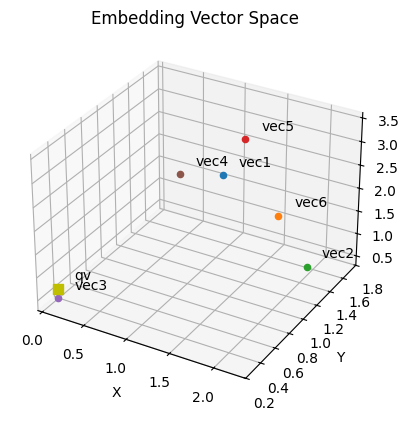

In [59]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

# 임베딩 미션

In [ ]:
name: "quickstart" 서버리스 인덱스 생성
dim: 1024

In [38]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

In [ ]:
임베딩 모델
multilingual-e5-large
upsert()
describe_index_stats()
query_vector : "애플이라는 기술 회사에 대해 알려주세요."
index.query()

In [72]:
index_name = "quickstart"

# Pinecone에 있는 모든 인덱스를 순회합니다.
for idx in pinecone_client.list_indexes():
    # 인덱스 이름이 "quickstart"와 일치하는 경우 해당 인덱스를 삭제합니다.
    if idx.name == index_name:
        pinecone_client.delete_index(idx.name)

In [73]:
from pinecone import ServerlessSpec
# Pinecone 인덱스를 생성합니다.
# 인덱스 이름은 "quickstart"이고, 차원은 1024, 메트릭은 코사인 유사도를 사용합니다.
# 인덱스는 AWS의 us-east-1 리전에서 서버리스 사양으로 생성됩니다.
quick_index = pinecone_client.create_index(
    name=index_name,
    dimension=1024,  # 모델 차원
    metric="cosine",  # 모델 메트릭
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

In [74]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

In [75]:
embeddings = pinecone_client.inference.embed (
  model='multilingual-e5-large',
  inputs = [d['text'] for d in data],
  parameters={"input_type":"passage", "truncate":"END"}
)
embeddings[0]

{'vector_type': dense, 'values': [0.0301055908203125, -0.0205841064453125, ..., -0.0302276611328125, 0.0241241455078125]}

In [76]:
#upsert를 위한 벡터 준비
vectors = []

for d, emb in zip(data, embeddings):
  vectors.append(
  {
    "id": d['id'],
    "values":emb['values'],
    "metadata":{'text':d['text']}
  }
)

In [77]:
quick_index

{
    "name": "quickstart",
    "metric": "cosine",
    "host": "quickstart-ou15dnm.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

In [78]:
quick_index = pinecone_client.Index('quickstart')

In [79]:
quick_index.upsert(
  vectors=vectors,
  namespace='quickstart_ns1'
)

{'upserted_count': 6}

In [81]:
quick_index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart_ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [82]:
# 쿼리 텍스트를 정의합니다.
query = "애플이라는 기술 회사에 대해 알려주세요."

# 쿼리 텍스트를 임베딩 벡터로 변환합니다.
embedding = pinecone_client.inference.embed(
    model="multilingual-e5-large",
    inputs=[query],
    parameters={
        "input_type": "query"  # 입력 타입을 쿼리로 설정합니다.
    }
)

# 첫 번째 임베딩 벡터를 출력합니다.
print(embedding[0])

{'vector_type': dense, 'values': [0.0113525390625, -0.0175933837890625, ..., -0.02020263671875, -0.00698089599609375]}


In [83]:
results = quick_index.query(
    namespace="quickstart_ns1",
    vector=embedding[0].values,
    top_k=3,
    include_values=False,
    include_metadata=True
)

# 검색 결과를 출력합니다.
print(results)

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.897184372,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.883859813,
              'values': []},
             {'id': 'vec6',
              'metadata': {'text': '애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, '
                                   '로널드 웨인에 의해 파트너십으로 설립되었습니다.'},
              'score': 0.867899835,
              'values': []}],
 'namespace': 'quickstart_ns1',
 'usage': {'read_units': 1}}
